### Traffic accident hotspot prediction using ConvLSTM

In [1]:
import os
import numpy as np
from os import walk
import pylab as plt
import tensorflow as tf
from tensorflow import keras 
from datetime import datetime
from operator import attrgetter
from PIL import Image, ImageOps
from ipywidgets import interact
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Conv2D, Dropout, Activation


2022-06-07 15:25:46.551032: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the second/third GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

2022-06-07 15:25:48.116461: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-06-07 15:25:48.152013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-07 15:25:48.154153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-07 15:25:48.156084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:86:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2

#### Get user input for USA State for which forecasting needs to be performed

In [3]:
states = next(walk("/data/fiona123/Project_GeneratedData/"))[1]

In [4]:
def f(State):
    global state_name
    state_name = State
    
val = interact(f, State=states)

interactive(children=(Dropdown(description='State', options=('Texas', 'Maine', 'New Jersey', 'Tennessee', 'Mis…

#### Load heatmaps and order them by date

In [5]:
state_path = "/data/fiona123/Project_GeneratedData/" + str(state_name) + "/"

state_file = next(walk(state_path))[2]
ordered_file = []

for i in state_file:
    datetime = datetime.strptime(i.split(".")[0], '%Y_%m_%d')
    ordered_file.append(datetime)

ordered_file = sorted(ordered_file)

In [6]:
new_file_list = []

for i in ordered_file:
    temp = i.strftime('%Y_%m_%d').replace('_0', '_')
    full_path = state_path + temp + ".png"
    new_file_list.append(full_path)  
    
new_file_list[5:10]

['/data/fiona123/Project_GeneratedData/Texas/2015_1_6.png',
 '/data/fiona123/Project_GeneratedData/Texas/2015_1_7.png',
 '/data/fiona123/Project_GeneratedData/Texas/2015_1_8.png',
 '/data/fiona123/Project_GeneratedData/Texas/2015_1_9.png',
 '/data/fiona123/Project_GeneratedData/Texas/2015_1_10.png']

#### Prepare data for training

In [7]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 15, :, :]
    return x

In [8]:
#(samples, time, channels, rows, cols) 
x = np.array([np.array(Image.open(fname)) for fname in new_file_list])
x = np.expand_dims(x, axis=0)
print(x.shape)

x_shifted = create_shifted_frames(x)
print(x_shifted.shape)

(1, 2192, 119, 120)
(1, 2177, 119, 120)


In [9]:
x = x.reshape(x.shape[1],1,x.shape[3],x.shape[2],1)
print(x.shape)
x_shifted = x_shifted.reshape(x_shifted.shape[1],1,x_shifted.shape[3],x_shifted.shape[2],1)

(2192, 1, 120, 119, 1)


#### Define the ConvLSTM Model

In [10]:
seq = Sequential()

seq.add(Conv2D(filters=10, kernel_size=(3,3), input_shape=(None, x.shape[2], x.shape[3], 1),
                   padding='same'))

seq.add(Dropout(0.30))
seq.add(BatchNormalization())
seq.add(Activation(activations.relu))

seq.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                   padding='same', return_sequences=True))


seq.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

seq.compile(loss='binary_crossentropy', optimizer='adam')

2022-06-07 15:25:48.822405: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 15:25:48.833830: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200000000 Hz
2022-06-07 15:25:48.836542: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6a2c420 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-07 15:25:48.836570: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-07 15:25:49.035822: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6a2f140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-07 15:25:49.035902: I 

In [11]:
seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, 120, 119, 10 100       
_________________________________________________________________
dropout (Dropout)            (None, None, 120, 119, 10 0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, 120, 119, 10 40        
_________________________________________________________________
activation (Activation)      (None, None, 120, 119, 10 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 120, 119, 10 7240      
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 120, 119, 10 7240      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, 120, 119, 1) 9

#### Training ConvLSTM model 1500 heatmaps at epochs

In [12]:
seq.fit(x[:1500], x[:1500], batch_size=32,
        epochs=20, validation_split=0.3)

Epoch 1/20


2022-06-07 15:25:54.250288: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-06-07 15:25:56.102485: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


33/33 [==============================] - 3s 81ms/step - loss: 0.4724 - val_loss: 0.0663
Epoch 2/20
33/33 [==============================] - 2s 57ms/step - loss: -0.4952 - val_loss: -1.3301
Epoch 3/20
33/33 [==============================] - 2s 57ms/step - loss: -1.8616 - val_loss: -2.4622
Epoch 4/20
33/33 [==============================] - 2s 58ms/step - loss: -2.9049 - val_loss: -3.4204
Epoch 5/20
33/33 [==============================] - 2s 56ms/step - loss: -3.7365 - val_loss: -4.1206
Epoch 6/20
33/33 [==============================] - 2s 57ms/step - loss: -4.3550 - val_loss: -4.6899
Epoch 7/20
33/33 [==============================] - 2s 57ms/step - loss: -4.9037 - val_loss: -5.2278
Epoch 8/20
33/33 [==============================] - 2s 56ms/step - loss: -5.4291 - val_loss: -5.7455
Epoch 9/20
33/33 [==============================] - 2s 58ms/step - loss: -5.9400 - val_loss: -6.2513
Epoch 10/20
33/33 [==============================] - 2s 57ms/step - loss: -6.4377 - val_loss: -6.7542
Ep

#### Predict future spatio-temporal heatmaps to compare and calculate accuracy

In [13]:
print(len(x))

point = 2185
number_of_days_to_predict = 7
track = x[point:point+number_of_days_to_predict][::, ::, ::]

print(track.shape)

2192
(7, 1, 120, 119, 1)


Mean SSIM Value of 15 image predictions:  0.956906052798691


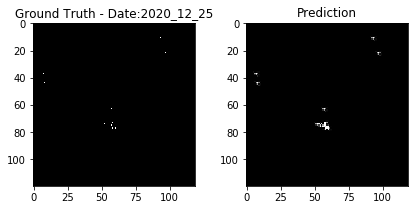

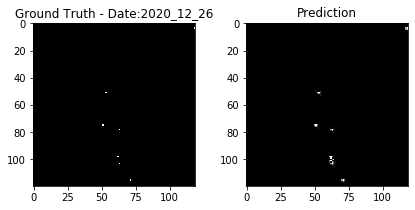

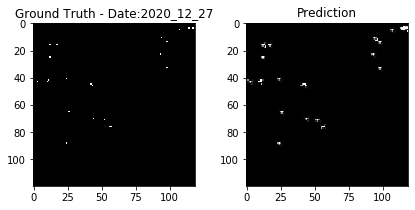

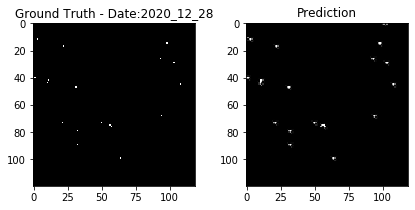

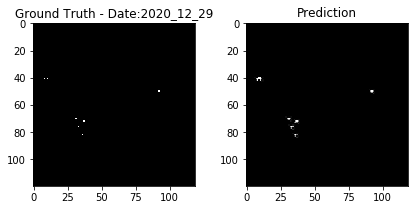

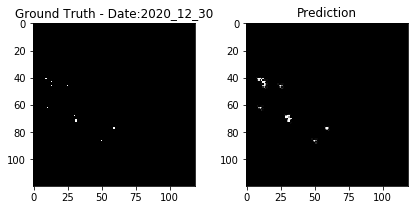

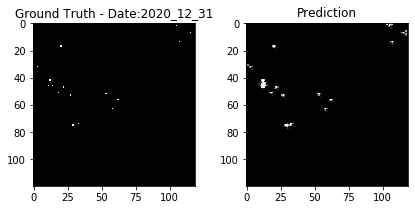

In [14]:
import numpy as np
np.set_printoptions(threshold=np.inf)
from skimage import img_as_ubyte


track_pred = seq.predict(track[::, ::, ::, ::]) 
track_pred = img_as_ubyte(track_pred)

ssim_values = []
for i in range(number_of_days_to_predict):
    fig = plt.figure(figsize=(7, 3))
    ax = fig.add_subplot(121)
    plt.title(f'Ground Truth - Date:{new_file_list[i+point].split("/")[5].split(".")[0]}', fontsize=12)
    gt = x[i+point][0,::, ::, 0]
    plt.imshow(gt, cmap="gray")
    
    ax = fig.add_subplot(122)
    plt.title('Prediction', fontsize=12)
    pred = track_pred[i][0,::, ::, 0]
    plt.imshow(pred,cmap="gray")
    
    ssim_values.append(ssim(gt, pred))
    
print("Mean SSIM Value of 15 image predictions: " , np.mean(ssim_values))

#### Create future days (after 2020) to check the prediction

In [15]:
import pandas as pd

predicted_new_days_list = pd.date_range(start = "2021-01-01", end = "2022-12-31",freq='d').strftime("%Y_%m_%d").tolist()
print(len(predicted_new_days_list))

730


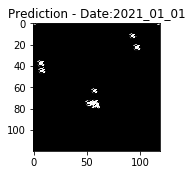

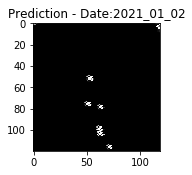

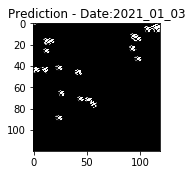

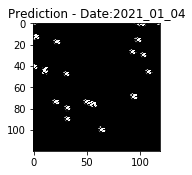

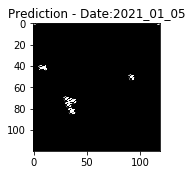

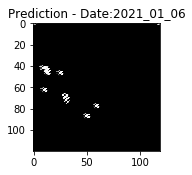

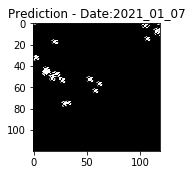

In [16]:
track_pred_NEW = seq.predict(track_pred) 

for i in range(7):
    fig = plt.figure(figsize=(5, 3))
    
    ax = fig.add_subplot(121)
    plt.title(f'Prediction - Date:{predicted_new_days_list[i]}', fontsize=12)

    toplot = track_pred_NEW[i][0,::, ::, 0]
    plt.imshow(toplot, cmap="gray")